# **Exemplo 2: Estimativa de fase quântica aplicada para encontrar a energia do estado fundamental da molécula $H_2$** 
## Neste exemplo vamos usar a estimativa de fase quântica para discutir fontes de erros em computadores quânticos.    
* ### A estimativa de fase quântica (Quantum phase estimation - QPE) é um dos principais algoritmos quânticos, sendo utilizado como subrotina em diversos outros algoritmo, como a fatoração de Shor e o algoritmo de sistemas linereas HHL (Harrow, Hassidin e Lloyd).
* ### Uma matriz unitária, $U$, possui autovalores na forma $e^{ i 2 \pi \phi}$, ou seja, se $|\psi \rangle $ é um autovetor de $U$ então $U |\psi \rangle = e^{ i 2 \pi \phi} |\psi \rangle$.
* ### A estimativa de fase quântica é utilizada para estimar $\phi$.
* ### O algoritmo possui dois registros quânticos, um para preparar o estado $|\psi \rangle $  e outro para guardar o valor de $\phi$ na forma binária.
* ### Para mais informações ver  Computação Quântica e Informação Quântice de M.A. Nielsen e I.L. Chuang.  

 ## Neste exemplo vamos aplicar o algoritmo de estimativa de fase para encontrar a energia do estado fundamental da moléluca $H_2$. 
 * ### Dado uma base adequada e considerando a simetria do problema, podemos escrever o Hamiltoniano da molécula como uma matriz 2 x 2:
$H = \begin{pmatrix}
-1.8310 & 0.1813 \\
0.1813 & -0.2537 
\end{pmatrix}$

* ### Se $| \psi_0 \rangle$ é o estado fundamental de $H$, então $U |\psi_0 \rangle = e^{-iHt} |\psi_0 \rangle = e^{-iEt} |\psi_0 \rangle = e^{i 2 \pi \phi} |\psi_0 \rangle$.
* ### Sabendo o valor de $\phi$ podemos então calcular a energia do estado fundamental $E = -2 \pi \phi/t$. 
* ### Neste caso a energia é -1,851 570 929 351 19 a.u.
* ### Mais informaçõs: Du J., Xu N., Peng X., Wang P., Wu S., Lu D. Phys. Rev. Lett., 104, 030502 (2010).

In [1]:
# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, QuantumRegister, ClassicalRegister, providers
from qiskit.quantum_info import Statevector, Operator
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from qiskit.tools import *
from qiskit.providers.aer  import  noise
from ibm_quantum_widgets import *
from qiskit.result import QuasiDistribution
from qiskit.extensions import UnitaryGate
from qiskit_ibm_runtime import QiskitRuntimeService, Sampler, Estimator, Session, Options
from qiskit.circuit.library import QFT
from qiskit.circuit.add_control import add_control
from qiskit.quantum_info.synthesis import OneQubitEulerDecomposer
# Loading your IBM Quantum account(s)
service = QiskitRuntimeService(channel="ibm_quantum",token = '9fa79efa2b5d81d9ca1d5c9f33493ebc19df76d34ba3efeffff31dfce86bf83d7f0e6c527ecb4caaeb34835a429c49ad23f6ed9dc89029dabc2b73786b966663' )

# Python libraries
import matplotlib.pyplot as plt
import scipy as sc
import numpy as np
import time 

# AUma função para verifiacar o status do job submetido
def job_status(job):
    
    for k in range(240):
        status = job.status()
        msg = status.value
        if  status.name in ["QUEUED"]:
            if 'position_in_queue' in job_real.metrics().keys():
                pos = job.metrics()['position_in_queue']
                print(msg +  ' and the position in queue is ' + str(pos), end='\r')
            else:
                print(msg + ' Waiting position in queue', end='\r')
        if  status.name in ["DONE", "CANCELLED", "ERROR"]:
            print(msg, end='\r')
            break
        if  status.name in ["RUNNING"]:
            print(msg, end='\r')
            
        time.sleep(2)
             
    return

## Vamos criar o circuito da estimativa de fase
* ### O algoritmo possui dois registros quânticos, um para preparar o estado $|\psi \rangle $  e outro para guardar o valor de $\phi$ na forma binária.
* ### O primeiro regitro deve ter o tamanho suficiente para comportar $|\psi \rangle $.
* ### O número de qubits do segundo registro depende da precisão que queremos estimar $\phi$.

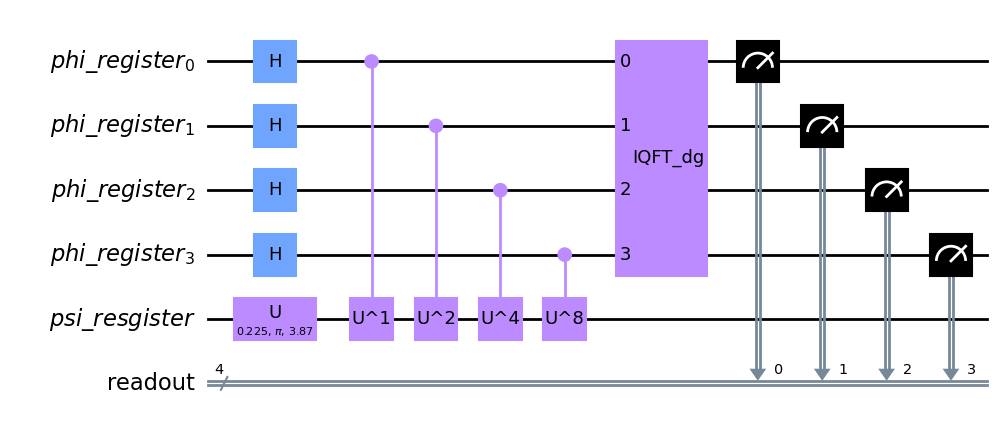

In [2]:
# Vamos estimar phi com 4 bits
nbit = 4
phi_register = QuantumRegister(nbit,'phi_register')

# Vamos precisar também de um registro clássico para cada bit 
c = ClassicalRegister(nbit,'readout')

#Para esse problema precisamos apenas de 1 qbit para psi
psi_register = QuantumRegister(1,'psi_resgister')

# Criamos o circuito
circ = QuantumCircuit(phi_register,psi_register,c)

################################################################
# Adicionamos as portas                                        #  
################################################################

# Primeiro precisamos preparar o estado psi. Neste caso sabemos que o estado é  -0.993624511809569 |0> + 0.112740097264441 |1>. 
# Podemos criar esse estado usando a porta u3([0.2259 pi 3.8667])
circ.u(0.225, np.pi, 3.8667,psi_register)

# O algoritmo começa colocando todos os qubits phi_register em superposição uniforme. Aplicamos então um Hadamard para cada qubit
circ.h(phi_register)

# Aplicamos n portas controladas U^(2^j) no qubit psi, o control é o qubit k do registro phi
H = np.array([[-1.8310 ,  0.1813],[0.1813 , -0.2537]])
for k in range(nbit):
    U = Operator(sc.linalg.expm(-1j*H*(2**k)))
    gate  = UnitaryGate(U, label = 'U^'+str(2**k))
    cgate = add_control(gate,1, label = None, ctrl_state = '1')
    circ.append(cgate, [phi_register[k], psi_register] )

# Transformada de Fourier Quântica inversa
circ.compose(QFT(nbit, inverse=True), qubits = phi_register, inplace=True)

# Medidas
circ.measure(phi_register ,c)

circuit_drawer(circ, output='mpl')

* ### Simulando circuito.

In [3]:
backend = service.backend("ibmq_qasm_simulator")
optimized_circ = transpile(circ,backend)
shots = 5000
options = Options()
options.execution.shots = shots 
sampler= Sampler(backend,options=options)

#Run
job = sampler.run(optimized_circ)

job_status(job)

In [4]:
job_status(job)

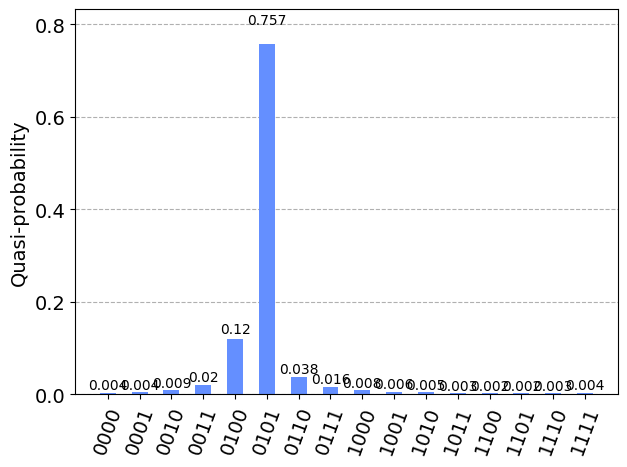

In [5]:
result=job.result()
probs = result.quasi_dists[0].binary_probabilities()
plot_histogram(probs)

* ### Pegamos o resultado de maior probabilidade para calcular $\phi$. 
* ### Ex: Se o número de bits for 3 e o resultado de maior probabilidade for '101' (5 em binário), $\phi = 5/2^3 = 0.625 $ .  

In [6]:
max_key = max(probs, key=probs.get)
max_val = probs.get(max_key)
phi = int(max_key,2)/ (2 ** nbit)
E = -2* np.pi*phi
print('The state with maximum probability ' + str(max_val) + ' is the state ' + max_key)
print('phi = ', phi)
print('Energy =', E)
print('Real Energy = -1.85157092935119')

The state with maximum probability 0.757 is the state 0101
phi =  0.3125
Energy = -1.9634954084936207
Real Energy = -1.85157092935119


* ### Vamos agora executar o circuito no computador real sem nenhum procedimento de otimização, supressão ou mitigação de erros

In [7]:
#esolhendo o computador
backend_real = service.get_backend('ibmq_manila')
# "Compilando" o circuito sem nenhum tipo de otimização
optimized_circ_real  = transpile(circ,backend_real , optimization_level = 0)
options = Options()
#Usando mesmo número de medidas como acima
options.execution.shots = shots
#Definindo qu enão usaremos nenhum procedimeno de mitigação de erro
options.resilience_level = 0

sampler_real  = Sampler(backend_real ,options=options)

#Run
job_real  = sampler_real .run(optimized_circ_real)

In [18]:
job_status(job_real)

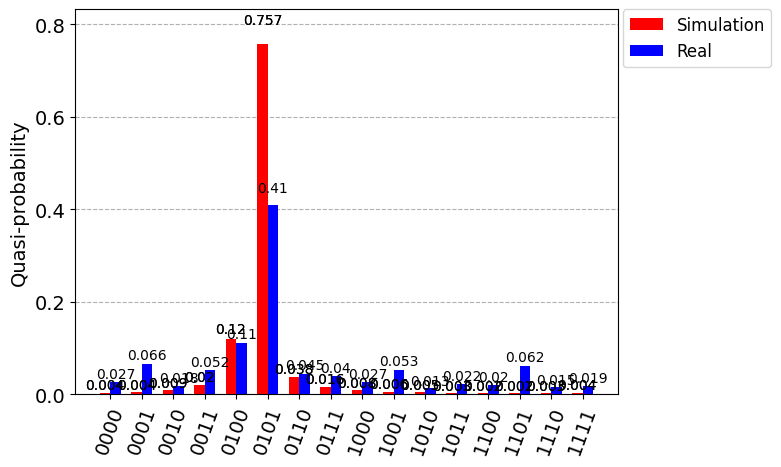

In [19]:
result_real=job_real.result()
probs_real = result_real.quasi_dists[0].binary_probabilities()
plot_histogram([probs, probs_real],legend =['Simulation', 'Real'],color = ['r','b'])

## Otimizando o circuito quântico
* ### Para ser executado em um computador real, o circuito quântico tem que ser compilado para a "linguagem do computador".
* ### No qiskit a compilação é feita pela rotina "transpile" e possui 4 níveis de otimização. 
* ### O nível o é mais simples e somente traduz o circuito em termos de portas lógicas "primitivas" que o computador "sabe" implementar, além de introduzir swaps para implemetar portas controladas entre dois 2 qubits que não se comunicam entre si.  
* ### Em níveis mais altos, vários "truques" são utilizados para simplificar o circuito.

* Vejamos a topologia do computador esolhico. O qubit 0 não interage com o 2. Assim qualquer porta controlada entre 0 e 2 somente pode ser feita usando swaps adicionais. EX: trocamos 0 com 1, implementamos a porta controlada entre 1 e 2 e depois trocamos 1 com 0 novamente.

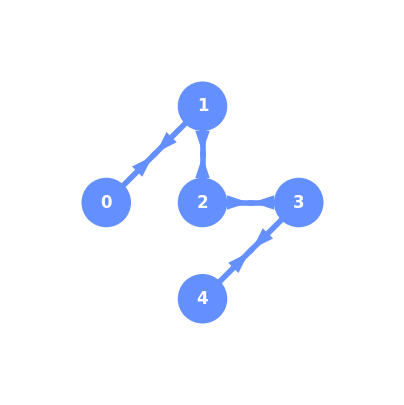

In [20]:
plot_gate_map(backend_real,plot_directed = True, label_qubits = True)

*  A baixa conectividade afeta a compilação, resultando em circuitos complexos e de difícil implementação. Podemos comparar os diferentes níveis de otimização.

In [21]:
optimized_circ_real_l0  = transpile(circ,backend_real , optimization_level = 0)
optimized_circ_real_l1  = transpile(circ,backend_real , optimization_level = 1)
optimized_circ_real_l2  = transpile(circ,backend_real , optimization_level = 2)
optimized_circ_real_l3  = transpile(circ,backend_real , optimization_level = 3)
print('optimization level=0  ' + str(optimized_circ_real_l0.depth()))
print('optimization level=1  ' + str(optimized_circ_real_l1.depth()))
print('optimization level=2  ' + str(optimized_circ_real_l2.depth()))
print('optimization level=3  ' + str(optimized_circ_real_l3.depth()))

optimization level=0  108
optimization level=1  95
optimization level=2  92
optimization level=3  86


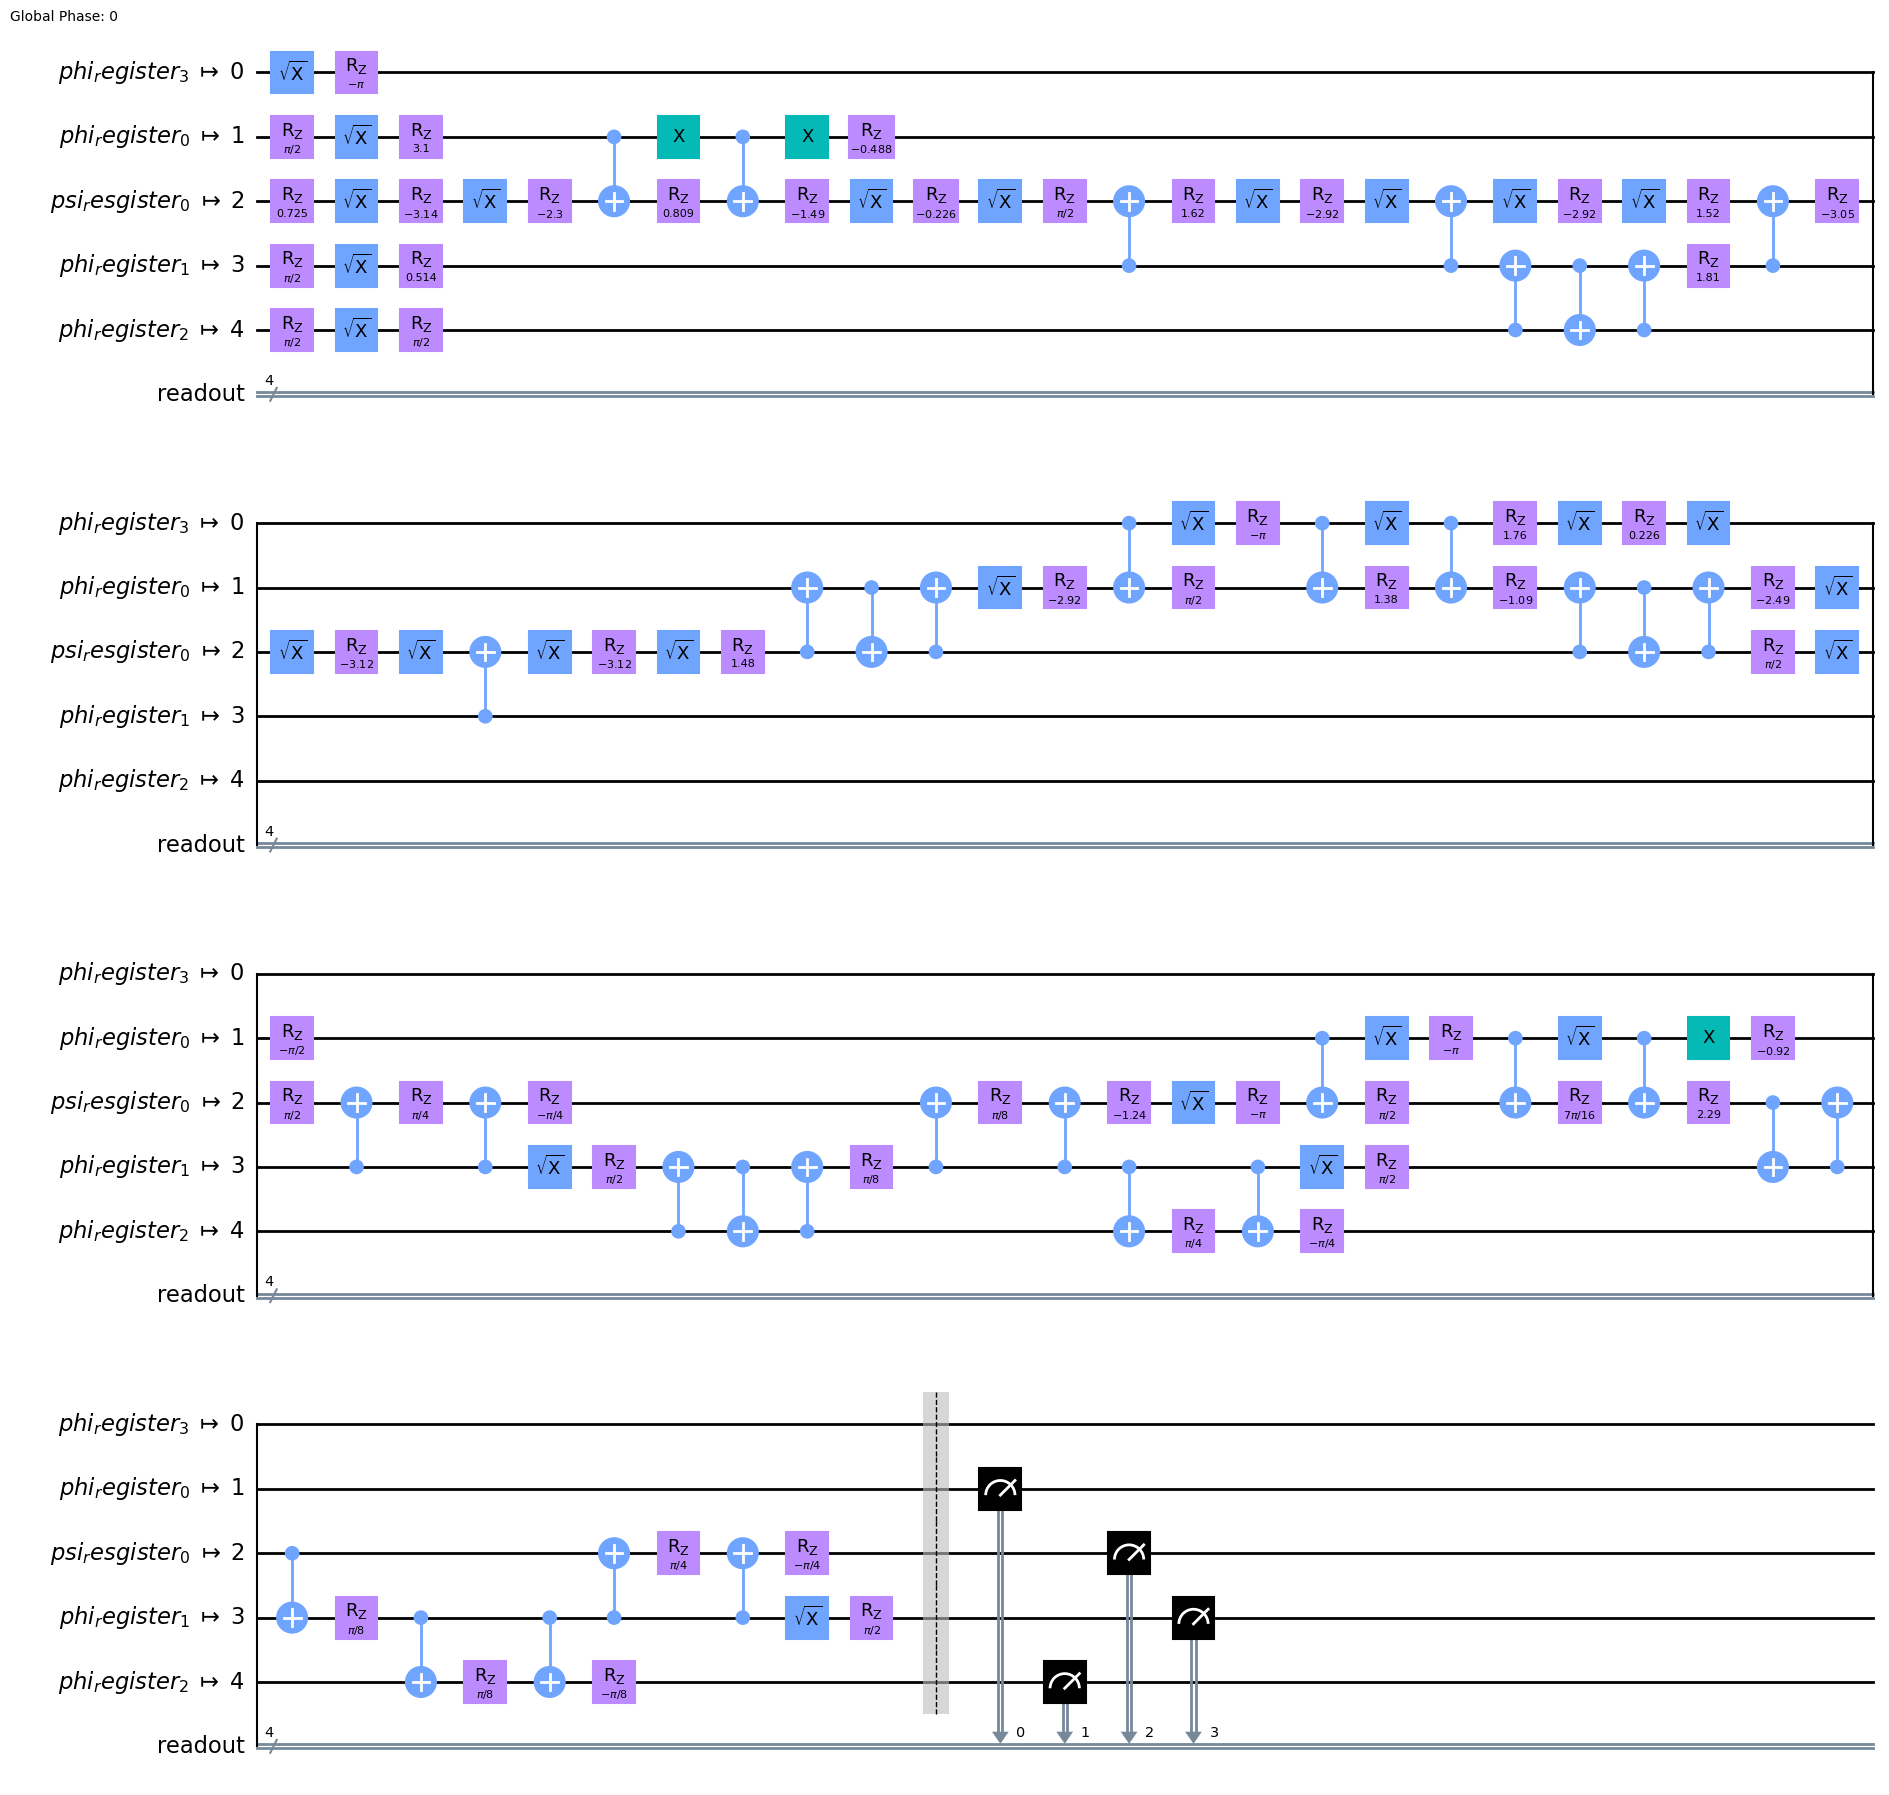

In [22]:
# Vamos ver o circuito mais otimizado
circuit_drawer(optimized_circ_real_l3, output='mpl')

In [23]:
#Vamos então executar o circuito otimizado
job_real_l3  = sampler_real.run(optimized_circ_real_l3)
job_status(job_real_l3)

/tmp/ipykernel_80/386241088.py:7: DeprecationWarning: The 'bss.seconds' attribute is deprecated as of qiskit-ibm-runtime 0.11.1 and will be removed no sooner than 3 months after the release date. Use the 'usage.quantum_seconds' attribute instead.
  if 'position_in_queue' in job_real.metrics().keys():


In [43]:
job_status(job_real_l3)

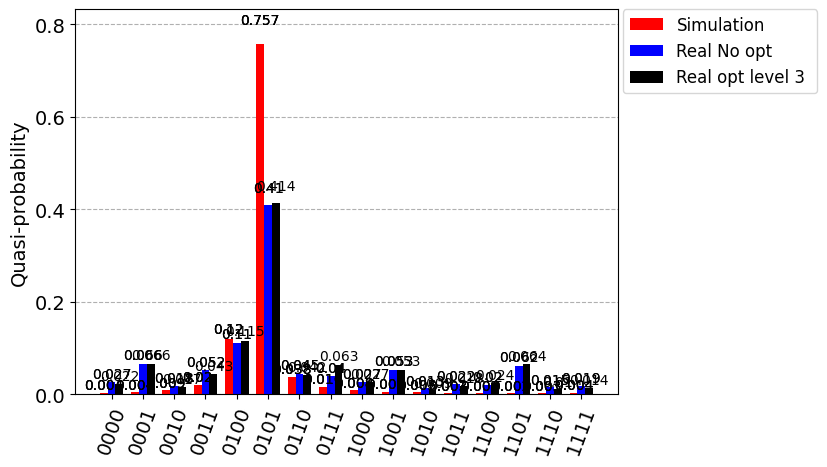

In [29]:
result_real_l3=job_real_l3.result()
probs_real_l3 = result_real_l3.quasi_dists[0].binary_probabilities()
plot_histogram([probs, probs_real, probs_real_l3],legend =['Simulation', 'Real No opt', 'Real opt level 3 '],color = ['r','b','k'])

* ## Mitigando erros
* ### No qiskit podemos escolher o método de mitigação com o parâmetro resilience_level . 
* ### O nível 0 não utilizada nenhum método de mitigação. 
* ### level 1 - Twirled Readout Error Extinction para corrigir erros de leitura.
* ### level 2 - Zero Noise Extrapolation (Apenas quando queremos estimar uma observável)
* ### level 3 - Probabilistic Error Cancellation (Apenas quando queremos estimar uma observável)

In [30]:
options = Options()
options.execution.shots = shots
options.resilience_level = 1
sampler_real_r1  = Sampler(backend_real ,options=options)

In [31]:
#Executando o circuito mais otimizado como resilience_level = 1
job_real_l3_r1  = sampler_real_r1.run(optimized_circ_real_l3)
job_status(job_real_l3_r1)

/tmp/ipykernel_80/3658490333.py:7: DeprecationWarning: The 'bss.seconds' attribute is deprecated as of qiskit-ibm-runtime 0.11.1 and will be removed no sooner than 3 months after the release date. Use the 'usage.quantum_seconds' attribute instead.
  if 'position_in_queue' in job_real.metrics().keys():


In [45]:
job_status(job_real_l3_r1)

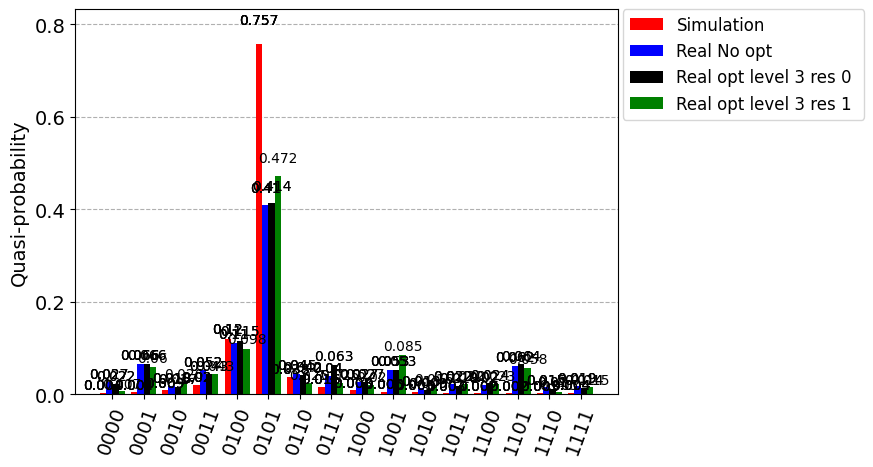

In [46]:
result_real_l3_r1=job_real_l3_r1.result()
probs_real_l3_r1 = result_real_l3_r1.quasi_dists[0].binary_probabilities()
plot_histogram([probs, probs_real, probs_real_l3, probs_real_l3_r1], 
               legend =['Simulation', 'Real No opt', 'Real opt level 3 res 0 ', 'Real opt level 3 res 1 ']
               ,color = ['r','b','k','g'])

In [35]:
if 'position_in_queue' in job_real_l3_r1.metrics().keys():
    print('exist')

exist


/tmp/ipykernel_80/2073332047.py:1: DeprecationWarning: The 'bss.seconds' attribute is deprecated as of qiskit-ibm-runtime 0.11.1 and will be removed no sooner than 3 months after the release date. Use the 'usage.quantum_seconds' attribute instead.
  if 'position_in_queue' in job_real_l3_r1.metrics().keys():


In [42]:
job_status(job_real_l3_r1)

In [40]:
def job_status(job):
    
    for k in range(1):
        status = job.status()
        msg = status.value
        if  status.name in ["QUEUED"]:
            if 'position_in_queue' in job_real.metrics().keys():
                pos = job.metrics()['position_in_queue']
                print(msg +  ' and the position in queue is ' + str(pos), end='\r')
            #else:
                #print(msg + ' Waiting position in queue', end='\r')
        if  status.name in ["DONE", "CANCELLED", "ERROR"]:
            print(msg, end='\r')
            break
        if  status.name in ["RUNNING"]:
            print(msg, end='\r')
            
        time.sleep(2)
             
    return